[An excellent introduction to fast multipole methods](https://math.nyu.edu/faculty/greengar/shortcourse_fmm.pdf)
[Another good set of slides](https://nyu-hpc19.github.io/files/lec14.pdf)

In [1]:
import cutde
import scipy.linalg
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

/home/tbent/.miniconda3/envs/bie_notebooks/lib/python3.9/site-packages/cutde/fullspace.py:41: UserWarning: The obs_pts input array has Fortran ordering. Converting to C ordering. This may be expensive.
  warnings.warn(


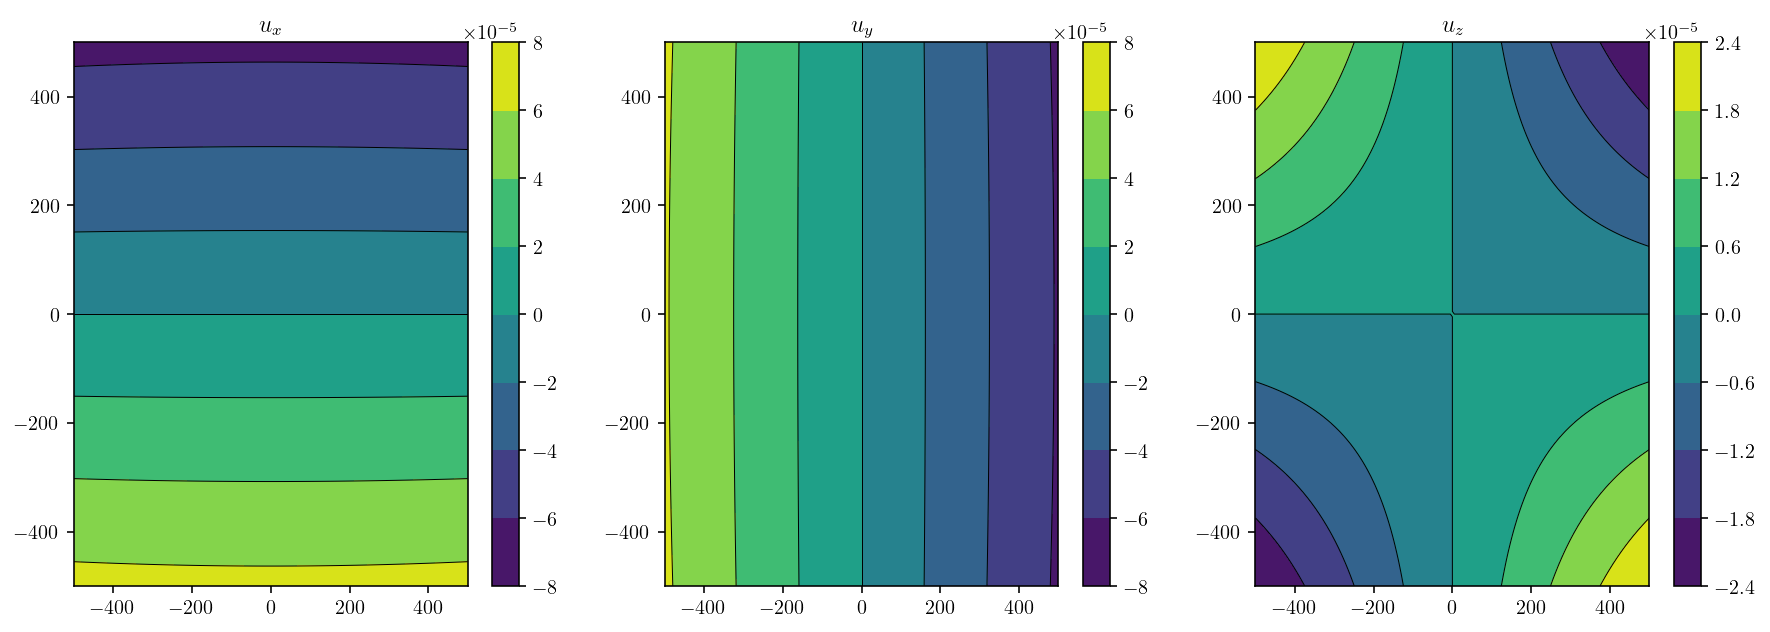

In [2]:
nobs = 100
W = 500
zoomx = [-W, W]
zoomy = [-W, W]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obsx, obsy = np.meshgrid(xs, ys)
pts = np.array([obsx, obsy, 0 * obsy]).reshape((3, -1)).T

fault_L = 1000.0
fault_H = 1000.0
fault_D = 7000.0
fault_pts = np.array(
    [
        [-fault_L, 0, -fault_D],
        [fault_L, 0, -fault_D],
        [fault_L, 0, -fault_D - fault_H],
        [-fault_L, 0, -fault_D - fault_H],
    ]
)
fault_tris = np.array([[0, 1, 2], [0, 2, 3]], dtype=np.int64)
fault_pts_tris = fault_pts[fault_tris]

slip = np.zeros((2, 3))
slip[:, 0] = 1.0

disp_mat = cutde.disp_all_pairs(
    obs_pts=pts, tris=fault_pts_tris, slips=slip, nu=0.25
)
disp = np.sum(disp_mat, axis=1).reshape((nobs, nobs, 3))

plt.figure(figsize=(15, 5))
for d in range(3):
    plt.subplot(1, 3, 1 + d)
    cntf = plt.contourf(obsx, obsy, disp[:, :, d])
    plt.contour(obsx, obsy, disp[:, :, d], colors="k", linestyles="-", linewidths=0.5)
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.title(f"$u_{['x','y','z'][d]}$")
plt.show()

In [3]:
import tri_gauss

In [4]:
qxhat, qw = tri_gauss.get_tri_gauss(7)

In [5]:
np.sum(qw * qxhat[:,0])

0.3333333333333336

In [6]:
leg1 = fault_pts_tris[:,1,:] - fault_pts_tris[:,0,:]
leg2 = fault_pts_tris[:,2,:] - fault_pts_tris[:,0,:]
q_tri_pts = fault_pts_tris[:,0,None,:] + (qxhat[:,0])[None,:,None] * leg1[:,None,:] + (qxhat[:,1])[None,:,None] * leg2[:,None,:]
tri_normals = np.cross(leg1, leg2)
normal_lengths = np.linalg.norm(tri_normals, axis=1)
tri_normals /= normal_lengths[:, None]

In [7]:
q_tri_pts = q_tri_pts.reshape((-1,3))
q_tri_wts = (normal_lengths[:, None] * 0.5 * qw[None,:]).flatten()
q_tri_ns = np.tile(tri_normals[:,None,:], (1, qxhat.shape[0], 1)).reshape((-1, 3))

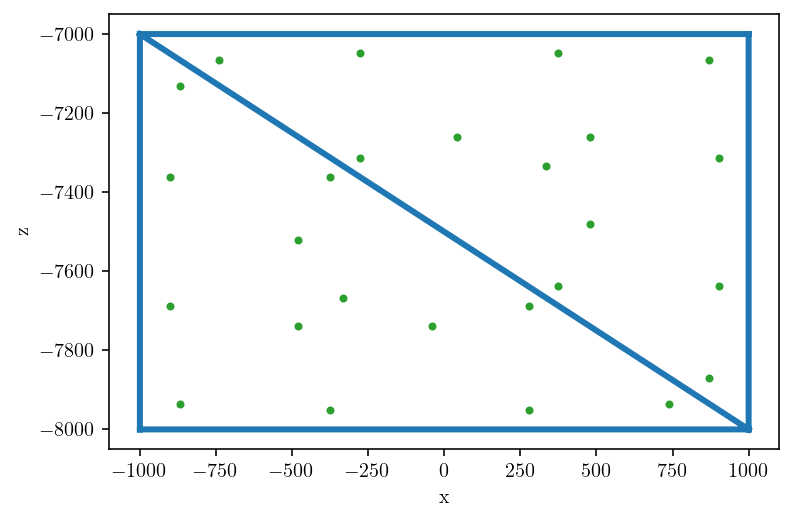

In [8]:
plt.triplot(fault_pts[:, 0], fault_pts[:, 2], fault_tris)
plt.plot(q_tri_pts[:,0],q_tri_pts[:,2], '.')
plt.xlabel("x")
plt.ylabel("z")
plt.show()

\begin{equation}
    T^*_{kj}(\mathbf{x},\mathbf{y}) = \frac{-1}{8\pi(1-\nu)r^2}\big[ \{(1-2\nu)\delta_{kj} + 3r_{,k}r_{,j} \}\frac{\partial r}{\partial \mathbf{n}} - (1 - 2\nu)\{n_jr_{,k} - n_kr_{,j}\}\big]
\end{equation}

In [9]:
def T_kernel(obs_pts, src_pts, src_normals):
    sep = obs_pts[:,None,:] - src_pts[None,:,:]

    r2 = np.sum(sep ** 2, axis=2)
    r = np.sqrt(r2)

    sep_over_r = sep / r[:,:,None]

    nu = 0.25
    C = -1.0 / (8 * np.pi * (1 - nu) * r2)

    kronecker_kj = np.eye(3)
    t1a = (1 - 2 * nu) * kronecker_kj

    t1b = 3 * sep_over_r[:, :, :, None] * sep_over_r[:, :, None, :]

    r_times_n = src_normals[:, None,:] * sep_over_r[:,:,:,None]
    drdn = np.sum(r_times_n[:,:,[0,1,2],[0,1,2]], axis=2)

    skew_rn = r_times_n - np.transpose(r_times_n, (0,1,3,2))

    t2 = (1 - 2 * nu) * skew_rn

    C.shape, t1a.shape, t1b.shape, drdn.shape, t2.shape

    Tstar = C[:,:,None,None] * ((t1a + t1b) * drdn[:,:,None,None] - t2)
    return np.transpose(Tstar, (0, 2, 1, 3))

In [10]:
Tstar = T_kernel(pts, q_tri_pts, q_tri_ns)
slip_xyz = np.zeros((q_tri_pts.shape[0],3))
slip_xyz[:,0] = 1.0
disp_q = np.sum(q_tri_wts[None, None, :] * np.sum(Tstar * slip_xyz[None, None, :, :], axis=3), axis=2)

In [11]:
disp_q = disp_q.reshape((*obsx.shape, 3))

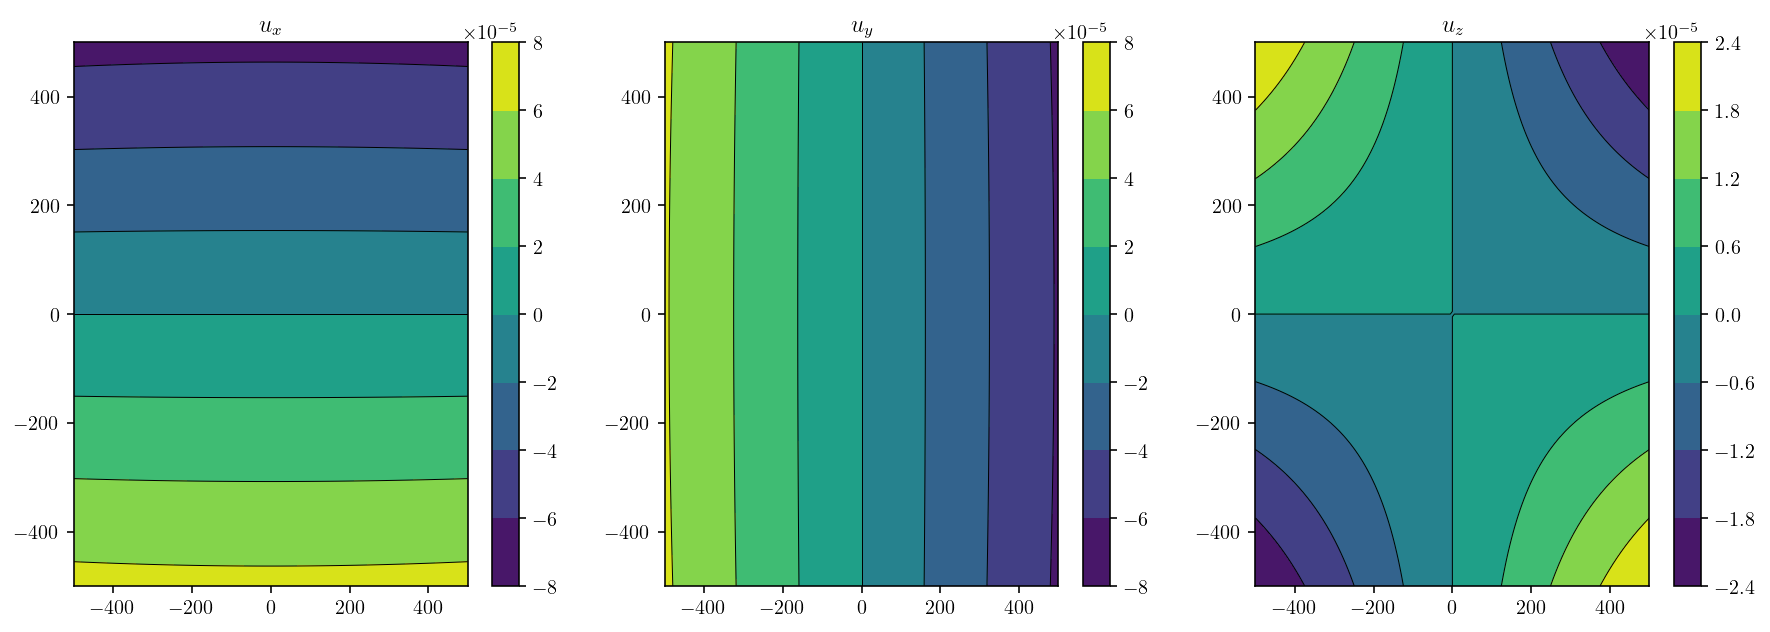

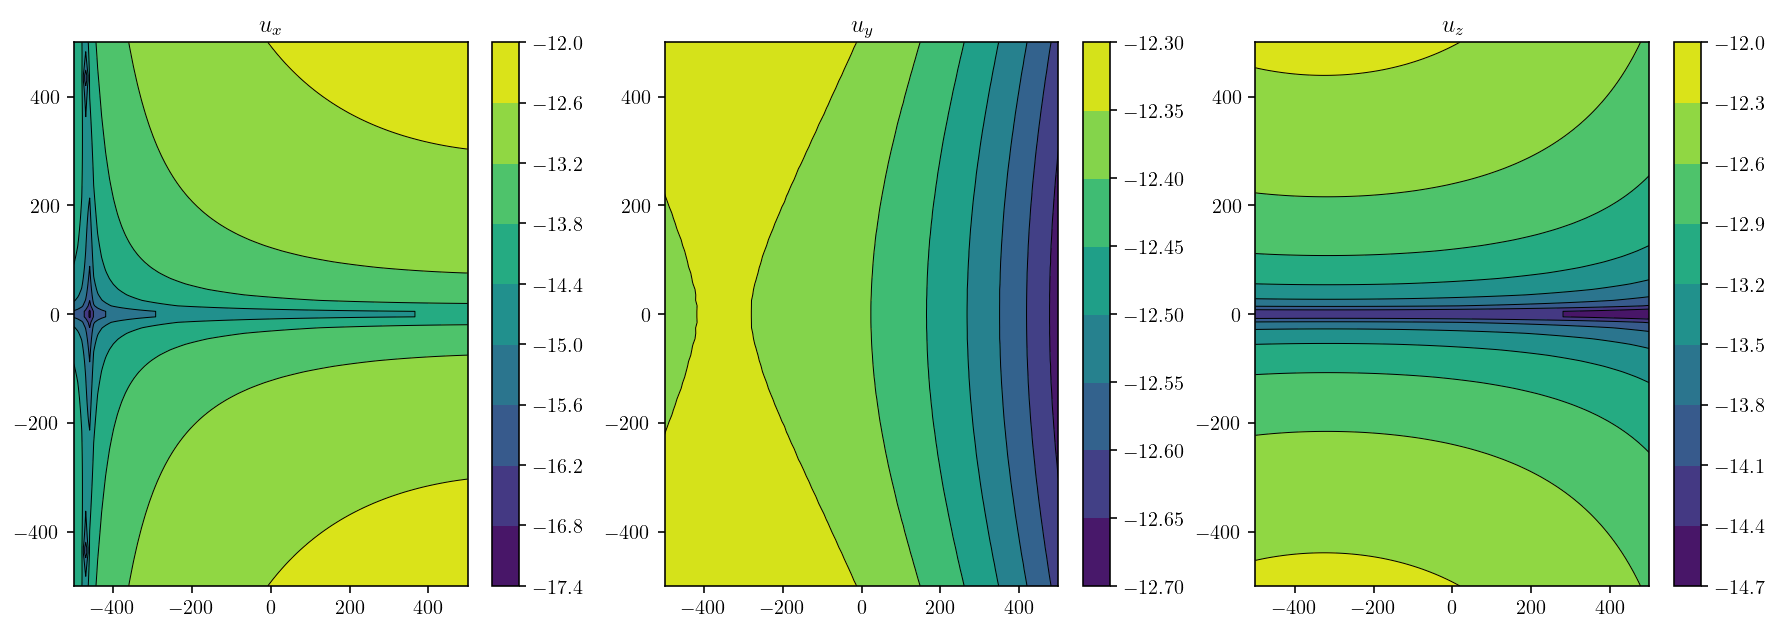

In [54]:
plt.figure(figsize=(15, 5))
for d in range(3):
    plt.subplot(1, 3, 1 + d)
    cntf = plt.contourf(obsx, obsy, disp_q[:, :, d])
    plt.contour(obsx, obsy, disp_q[:, :, d], colors="k", linestyles="-", linewidths=0.5)
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.title(f"$u_{['x','y','z'][d]}$")
plt.figure(figsize=(15, 5))

for d in range(3):
    logerror = np.log10(np.abs(disp_q[:, :, d] - disp[:, :, d]))
    plt.subplot(1, 3, 1 + d)
    cntf = plt.contourf(obsx, obsy, logerror)
    plt.contour(obsx, obsy, logerror, colors="k", linestyles="-", linewidths=0.5)
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.title(f"$u_{['x','y','z'][d]}$")
plt.show()

In [90]:
lebedev = np.loadtxt('https://people.sc.fsu.edu/~jburkardt/datasets/sphere_lebedev_rule/lebedev_031.txt')

In [91]:
np.deg2rad

<ufunc 'deg2rad'>

In [92]:
lebedev
phi = np.deg2rad(lebedev[:,1])
theta = np.deg2rad(lebedev[:, 0]) + pi
w = lebedev[:,2]

In [93]:
sx = np.sin(phi) * np.cos(theta)
sy = np.sin(phi) * np.sin(theta)
sz = np.cos(phi)
spts = np.array([sx, sy, sz]).T.copy()

In [94]:
f = 1 + sx + sy ** 2 + sx ** 2 * sy + sx ** 4 + sy ** 5 + sx ** 2 * sy ** 2 * sz ** 2

In [95]:
Itest = np.sum(4 * np.pi * w * f)

In [96]:
Itest - (216*np.pi / 35)

3.836930773104541e-13

In [97]:
def fmm_surf(center, r):
    return center + r * spts
center = np.mean(q_tri_pts, axis=0)
r = np.max(np.linalg.norm(q_tri_pts - center, axis=1))

In [98]:
check_surf = fmm_surf(center, 2.5 * r)
equiv_surf = fmm_surf(center, 1.1 * r)

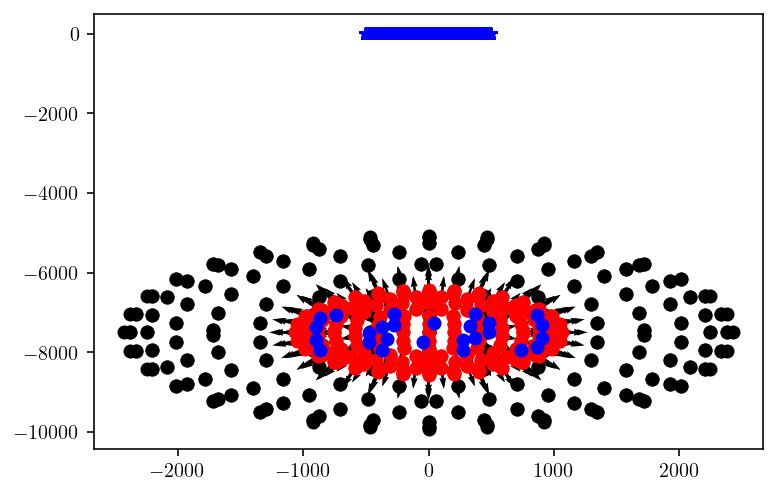

In [99]:
plt.plot(check_surf[:, 0], check_surf[:, 2], 'ko')
plt.plot(equiv_surf[:, 0], equiv_surf[:, 2], 'ro')
plt.plot(q_tri_pts[:, 0], q_tri_pts[:, 2], 'bo')
plt.plot(pts[:, 0], pts[:, 2], 'b*')
plt.quiver(equiv_surf[:, 0], equiv_surf[:, 2], spts[:,0], spts[:,2])
plt.show()

In [100]:
src_to_check_mat = T_kernel(check_surf, q_tri_pts, q_tri_ns)

In [101]:
src_to_check_v = np.sum(q_tri_wts[None, None, :] * np.sum(src_to_check_mat * slip_xyz[None, None, :, :], axis=3), axis=2).flatten()

In [102]:
equiv_to_check = T_kernel(check_surf, equiv_surf, spts)

In [103]:
lhs = 4 * np.pi * r ** 2 * w[None, None, :, None] * equiv_to_check

In [104]:
lhs.shape

(350, 3, 350, 3)

In [105]:
w.shape

(350,)

In [106]:
src_to_check_mat.shape

(350, 3, 26, 3)

In [107]:
n_equiv_dofs = w.shape[0] * 3

In [131]:
def reg_lstsq_inverse(M, alpha):
    U, eig, VT = np.linalg.svd(M)
    inv_eig = eig / (eig ** 2 + alpha ** 2)
    return (VT.T * inv_eig).dot(U.T)
lhs_inv = reg_lstsq_inverse(lhs.reshape((n_equiv_dofs,n_equiv_dofs)), 1e-7)

In [132]:
LL = lhs_inv.reshape((w.shape[0],3,w.shape[0],3))

In [144]:
np.linalg.svd(LL[:2,0,200:202,0])[1]

array([1.00034970e+05, 2.19755273e-06])

In [169]:
step = 4
for i in range(0,40,step):
    print('\n', i)
    U, S, V = np.linalg.svd(LL[i:(i+step),0,200+i:200+step+i,0])
    print('U', U)
    print('S', S)
    print('V', V)


 0
U [[-0.42045525  0.50954517  0.7334247   0.16021644]
 [-0.42045525  0.50954517 -0.66931499  0.33999785]
 [ 0.80144843  0.49584349  0.04250978  0.33168143]
 [-0.06414971 -0.48463045  0.11089891  0.86528584]]
S [2.08782678e+05 9.41403958e+04 2.66986471e-06 2.12243244e-06]
V [[-0.19900535 -0.19900535 -0.67852551 -0.67852551]
 [ 0.67852551  0.67852551 -0.19900535 -0.19900535]
 [-0.62119812  0.62119812  0.33780601 -0.33780601]
 [-0.33780601  0.33780601 -0.62119812  0.62119812]]

 4
U [[-0.19262107  0.41881341 -0.68036543 -0.56973268]
 [ 0.19262107  0.41881341  0.68036543 -0.56973268]
 [-0.68036543  0.56973268  0.19262107  0.41881341]
 [ 0.68036543  0.56973268 -0.19262107  0.41881341]]
S [98717.46339843 84091.67746489 22801.4161095  18739.81595782]
V [[ 0.13484834 -0.13484834 -0.69412962  0.69412962]
 [-0.22113075 -0.22113075  0.67164067  0.67164067]
 [ 0.69412962 -0.69412962  0.13484834 -0.13484834]
 [ 0.67164067  0.67164067  0.22113075  0.22113075]]

 8
U [[-0.5  0.5 -0.5 -0.5]
 [ 0.5 

In [157]:
LL[i:(i+2),0,200+i:202+i,0]

array([[ 81126.4413026 , -13299.04897899],
       [-13299.04898155,  81126.44130355]])

In [156]:
U * S * V.T

array([[47212.74513997, 33913.69616263],
       [47212.74514337, 33913.69616018]])

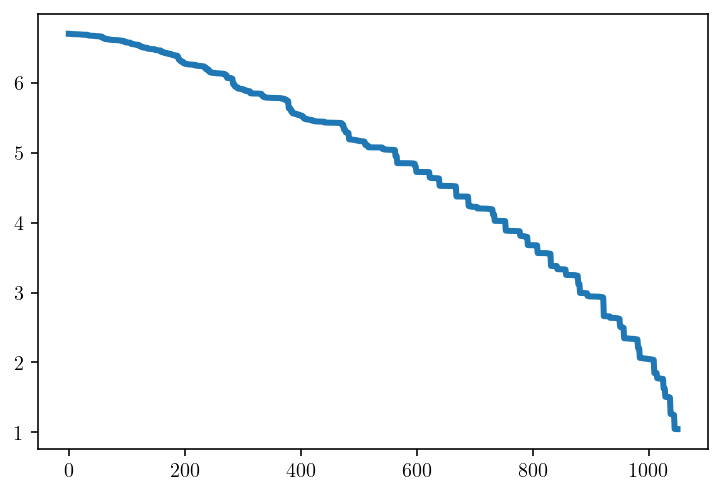

In [134]:
plt.plot(np.log10(np.linalg.svd(lhs_inv)[1]))

In [135]:
equiv = lhs_inv.dot(src_to_check_v).reshape((-1,3))

In [136]:
equiv_to_obs = T_kernel(pts, equiv_surf, spts).reshape((pts.shape[0],3,-1))

In [137]:
result = equiv_to_obs.dot((4 * np.pi * r ** 2 * w[:, None] * equiv).flatten()).reshape(disp.shape)

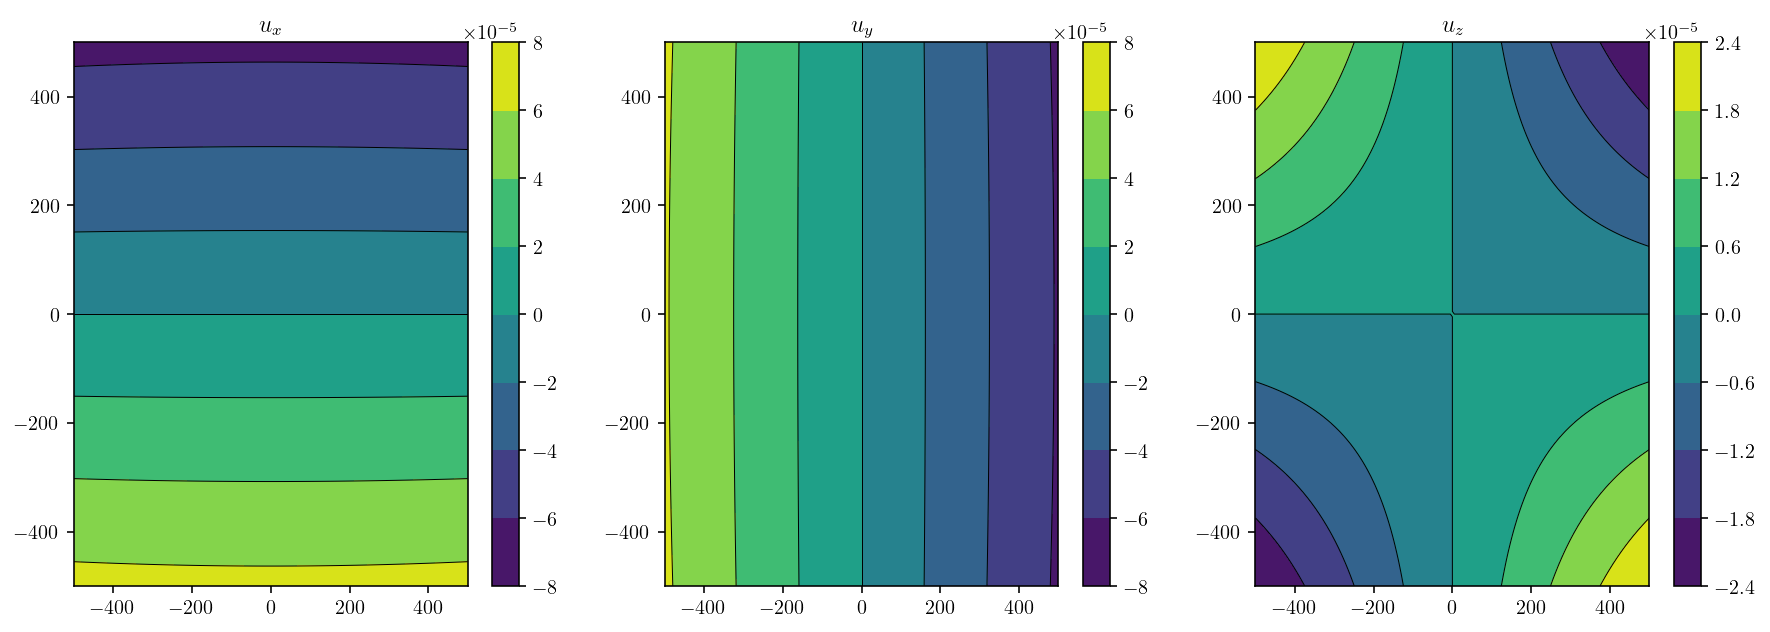

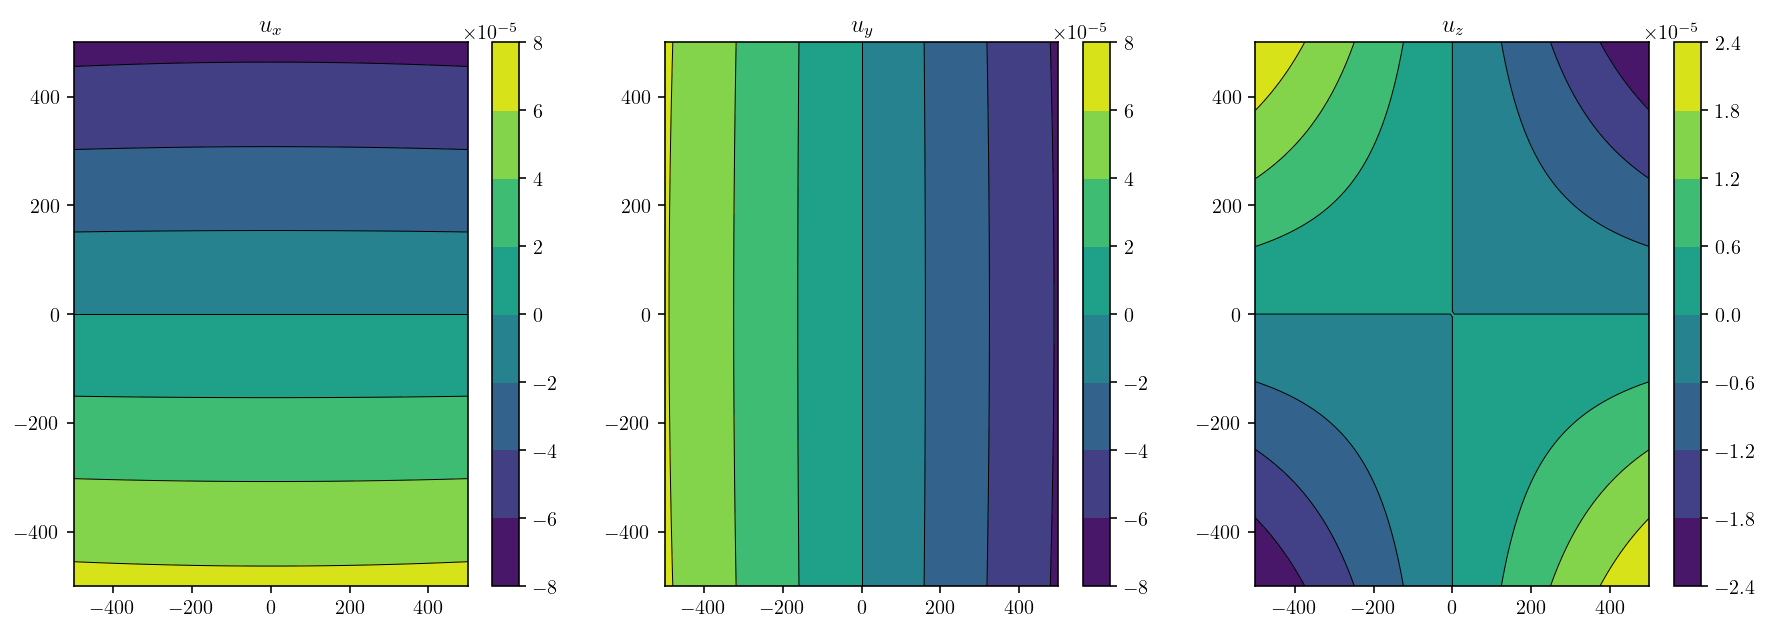

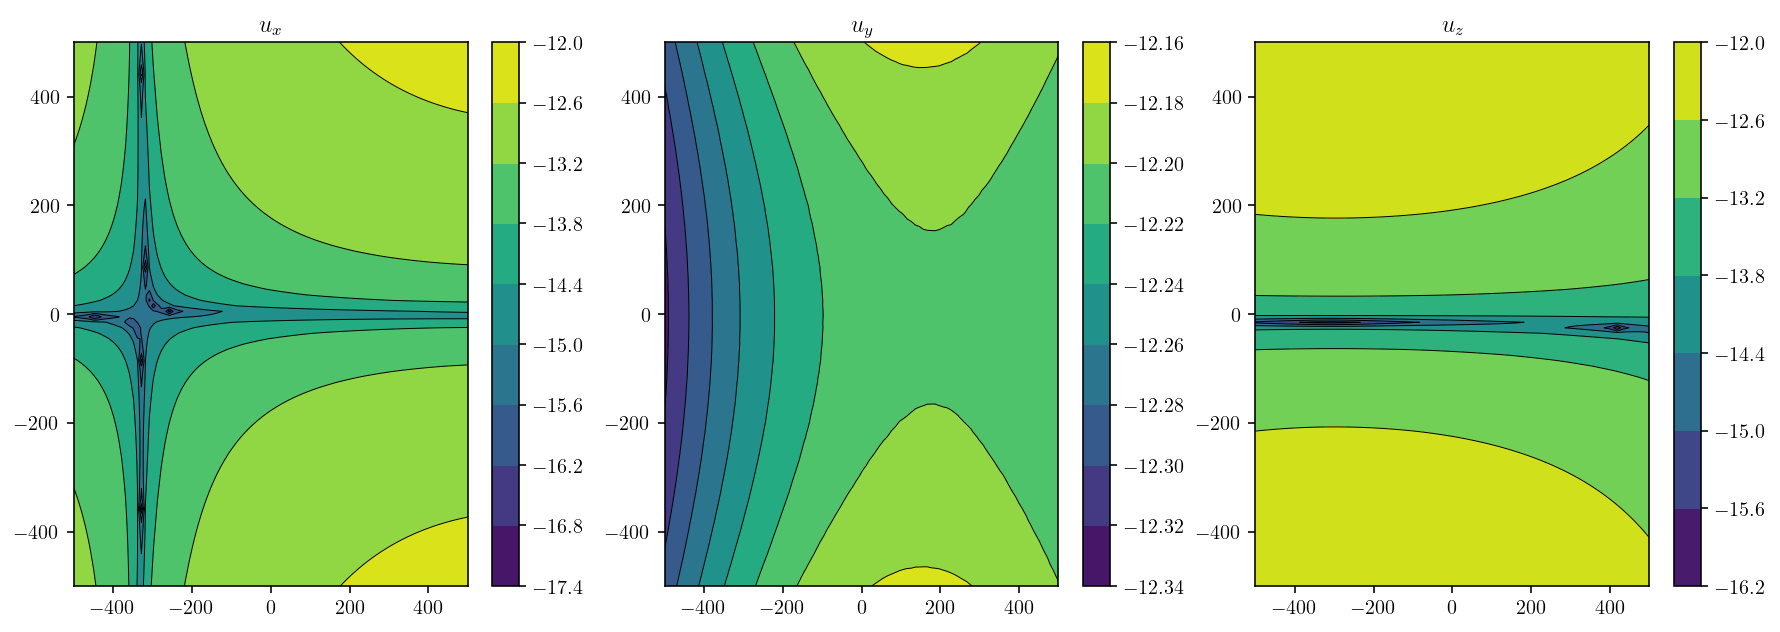

In [138]:
plt.figure(figsize=(15, 5))
for d in range(3):
    plt.subplot(1, 3, 1 + d)
    cntf = plt.contourf(obsx, obsy, disp[:, :, d])
    plt.contour(obsx, obsy, disp[:, :, d], colors="k", linestyles="-", linewidths=0.5)
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.title(f"$u_{['x','y','z'][d]}$")

plt.figure(figsize=(15, 5))
for d in range(3):
    plt.subplot(1, 3, 1 + d)
    cntf = plt.contourf(obsx, obsy, result[:, :, d])
    plt.contour(obsx, obsy, result[:, :, d], colors="k", linestyles="-", linewidths=0.5)
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.title(f"$u_{['x','y','z'][d]}$")
plt.figure(figsize=(15, 5))

for d in range(3):
    logerror = np.log10(np.abs((result[:, :, d] - disp[:, :, d])))# / disp[:, :, d]))
    plt.subplot(1, 3, 1 + d)
    cntf = plt.contourf(obsx, obsy, logerror)
    plt.contour(obsx, obsy, logerror, colors="k", linestyles="-", linewidths=0.5)
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.title(f"$u_{['x','y','z'][d]}$")
plt.show()